## DFBA with E. coli example

The following notebook shows a simple, but slow example of implementing dFBA using COBRApy and scipy.integrate.solve_ivp. This notebook shows a static optimization approach (SOA) implementation and should not be considered production ready.

The model considers only basic Michaelis-Menten limited growth on glucose.

In [2]:
import numpy as np
from tqdm import tqdm

from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import cobra
from cobra.test import create_test_model
model = create_test_model('textbook')

In [4]:
def add_dynamic_bounds(model, y):
    """Use external concentrations to bound the uptake flux of glucose."""
    biomass, glucose = y  # expand the boundary species
    glucose_max_import = -10 * glucose / (5 + glucose)
    model.reactions.EX_glc__D_e.lower_bound = glucose_max_import


def dynamic_system(t, y):
    """Calculate the time derivative of external species."""

    biomass, glucose = y  # expand the boundary species

    # Calculate the specific exchanges fluxes at the given external concentrations.
    with model:
        add_dynamic_bounds(model, y)

        cobra.util.add_lp_feasibility(model)
        feasibility = cobra.util.fix_objective_as_constraint(model)
        lex_constraints = cobra.util.add_lexicographic_constraints(
            model, ['Biomass_Ecoli_core', 'EX_glc__D_e'], ['max', 'max'])

    # Since the calculated fluxes are specific rates, we multiply them by the
    # biomass concentration to get the bulk exchange rates.
    fluxes = lex_constraints.values
    fluxes *= biomass

    # This implementation is **not** efficient, so I display the current
    # simulation time using a progress bar.
    if dynamic_system.pbar is not None:
        dynamic_system.pbar.update(1)
        dynamic_system.pbar.set_description('t = {:.3f}'.format(t))

    return fluxes

dynamic_system.pbar = None


def infeasible_event(t, y):
    """
    Determine solution feasibility.

    Avoiding infeasible solutions is handled by solve_ivp's built-in event detection.
    This function re-solves the LP to determine whether or not the solution is feasible
    (and if not, how far it is from feasibility). When the sign of this function changes
    from -epsilon to positive, we know the solution is no longer feasible.

    """

    with model:

        add_dynamic_bounds(model, y)

        cobra.util.add_lp_feasibility(model)
        feasibility = cobra.util.fix_objective_as_constraint(model)

    return feasibility - infeasible_event.epsilon

infeasible_event.epsilon = 1E-6
infeasible_event.direction = 1
infeasible_event.terminal = True

In [5]:
ts = np.linspace(0, 15, 100)  # Desired integration resolution and interval
y0 = [0.1, 10]

with tqdm() as pbar:
    dynamic_system.pbar = pbar

    sol = solve_ivp(
        fun=dynamic_system,
        events=[infeasible_event],
        t_span=(ts.min(), ts.max()),
        y0=y0,
        t_eval=ts,
        rtol=1e-6,
        atol=1e-8,
        method='BDF'
    )

t = 0.054: : 23it [00:04,  4.76it/s]


KeyboardInterrupt: 

In [ ]:
sol

  message: 'A termination event occurred.'
     nfev: 236
     njev: 5
      nlu: 21
      sol: None
   status: 1
  success: True
        t: array([ 0.        ,  0.15151515,  0.3030303 ,  0.45454545,  0.60606061,
        0.75757576,  0.90909091,  1.06060606,  1.21212121,  1.36363636,
        1.51515152,  1.66666667,  1.81818182,  1.96969697,  2.12121212,
        2.27272727,  2.42424242,  2.57575758,  2.72727273,  2.87878788,
        3.03030303,  3.18181818,  3.33333333,  3.48484848,  3.63636364,
        3.78787879,  3.93939394,  4.09090909,  4.24242424,  4.39393939,
        4.54545455,  4.6969697 ,  4.84848485,  5.        ,  5.15151515,
        5.3030303 ,  5.45454545,  5.60606061,  5.75757576,  5.90909091,
        6.06060606,  6.21212121,  6.36363636,  6.51515152,  6.66666667,
        6.81818182,  6.96969697,  7.12121212,  7.27272727,  7.42424242,
        7.57575758,  7.72727273,  7.87878788,  8.03030303,  8.18181818,
        8.33333333,  8.48484848,  8.63636364,  8.78787879,  8.93939

Text(0, 0.5, 'Glucose')

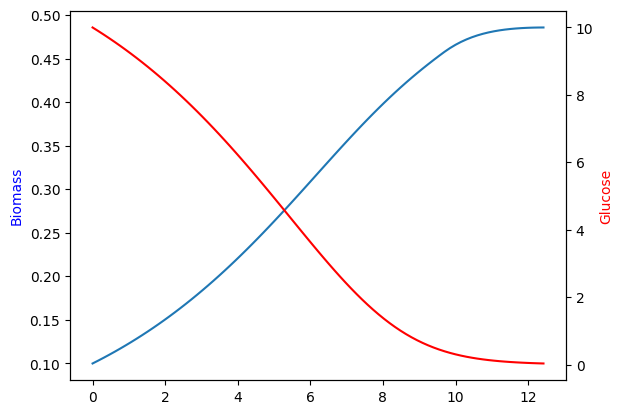

In [ ]:
ax = plt.subplot(111)
ax.plot(sol.t, sol.y.T[:, 0])
ax2 = plt.twinx(ax)
ax2.plot(sol.t, sol.y.T[:, 1], color='r')

ax.set_ylabel('Biomass', color='b')
ax2.set_ylabel('Glucose', color='r')


## DFBA with our model

In [6]:
from cobra.io import read_sbml_model

In [7]:
model = read_sbml_model('../../models/iMM904_progesterone_fixed.xml')

#fba_model.add_boundary(fba_model.metabolites.get_by_id('progesterone_e'), type='exchange')
model.add_boundary(model.metabolites.get_by_id('progesterone_c'), type='demand')

model.objective = model.reactions.R02216
model.optimize().objective_value

0.14285714285714285

In [10]:
model.exchanges

[<Reaction EX_epistest_SC_e at 0x7f477d6dd9d0>,
 <Reaction EX_epist_e at 0x7f477d6dd9a0>,
 <Reaction EX_ergst_e at 0x7f477d31fee0>,
 <Reaction EX_ergstest_SC_e at 0x7f477d31f880>,
 <Reaction EX_13BDglcn_e at 0x7f477d330250>,
 <Reaction EX_etha_e at 0x7f477d330970>,
 <Reaction EX_2hb_e at 0x7f477d330a00>,
 <Reaction EX_etoh_e at 0x7f477d3307f0>,
 <Reaction EX_fe2_e at 0x7f477d330a90>,
 <Reaction EX_fecost_e at 0x7f477d330c10>,
 <Reaction EX_2mbac_e at 0x7f477d330df0>,
 <Reaction EX_2mbald_e at 0x7f477d330040>,
 <Reaction EX_2mbtoh_e at 0x7f477d330b50>,
 <Reaction EX_2mppal_e at 0x7f477d330e80>,
 <Reaction EX_2phetoh_e at 0x7f477d330850>,
 <Reaction EX_fecostest_SC_e at 0x7f477d3300d0>,
 <Reaction EX_fmn_e at 0x7f477d330730>,
 <Reaction EX_3c3hmp_e at 0x7f477d330820>,
 <Reaction EX_3mbald_e at 0x7f477d2c0340>,
 <Reaction EX_for_e at 0x7f477d2c04c0>,
 <Reaction EX_fru_e at 0x7f477d2c06a0>,
 <Reaction EX_3mop_e at 0x7f477d2c0220>,
 <Reaction EX_4abut_e at 0x7f477d2c0730>,
 <Reaction EX_fum

In [ ]:
def add_dynamic_bounds(model, y):
    """Use external concentrations to bound the uptake flux of glucose."""
    biomass, glucose = y  # expand the boundary species
    glucose_max_import = -10 * glucose / (5 + glucose)
    model.reactions.EX_glc__D_e.lower_bound = glucose_max_import


def dynamic_system(t, y):
    """Calculate the time derivative of external species."""

    biomass, glucose = y  # expand the boundary species

    # Calculate the specific exchanges fluxes at the given external concentrations.
    with model:
        add_dynamic_bounds(model, y)

        cobra.util.add_lp_feasibility(model)
        feasibility = cobra.util.fix_objective_as_constraint(model)
        lex_constraints = cobra.util.add_lexicographic_constraints(
            model, ['BIOMASS_SC5_notrace', 'EX_glc__D_e'], ['max', 'max'])

    # Since the calculated fluxes are specific rates, we multiply them by the
    # biomass concentration to get the bulk exchange rates.
    fluxes = lex_constraints.values
    fluxes *= biomass

    # This implementation is **not** efficient, so I display the current
    # simulation time using a progress bar.
    if dynamic_system.pbar is not None:
        dynamic_system.pbar.update(1)
        dynamic_system.pbar.set_description('t = {:.3f}'.format(t))

    return fluxes

dynamic_system.pbar = None


def infeasible_event(t, y):
    """
    Determine solution feasibility.

    Avoiding infeasible solutions is handled by solve_ivp's built-in event detection.
    This function re-solves the LP to determine whether or not the solution is feasible
    (and if not, how far it is from feasibility). When the sign of this function changes
    from -epsilon to positive, we know the solution is no longer feasible.

    """

    with model:

        add_dynamic_bounds(model, y)

        cobra.util.add_lp_feasibility(model)
        feasibility = cobra.util.fix_objective_as_constraint(model)

    return feasibility - infeasible_event.epsilon

infeasible_event.epsilon = 1E-6
infeasible_event.direction = 1
infeasible_event.terminal = True

In [ ]:
ts = np.linspace(0, 15, 100)  # Desired integration resolution and interval
y0 = [0.1, 10]

with tqdm() as pbar:
    dynamic_system.pbar = pbar

    sol = solve_ivp(
        fun=dynamic_system,
        events=[infeasible_event],
        t_span=(ts.min(), ts.max()),
        y0=y0,
        t_eval=ts,
        rtol=1e-6,
        atol=1e-8,
        method='BDF'
    )

t = 12.487: : 251it [20:18,  4.86s/it]


In [ ]:
sol

  message: 'A termination event occurred.'
     nfev: 236
     njev: 5
      nlu: 21
      sol: None
   status: 1
  success: True
        t: array([ 0.        ,  0.15151515,  0.3030303 ,  0.45454545,  0.60606061,
        0.75757576,  0.90909091,  1.06060606,  1.21212121,  1.36363636,
        1.51515152,  1.66666667,  1.81818182,  1.96969697,  2.12121212,
        2.27272727,  2.42424242,  2.57575758,  2.72727273,  2.87878788,
        3.03030303,  3.18181818,  3.33333333,  3.48484848,  3.63636364,
        3.78787879,  3.93939394,  4.09090909,  4.24242424,  4.39393939,
        4.54545455,  4.6969697 ,  4.84848485,  5.        ,  5.15151515,
        5.3030303 ,  5.45454545,  5.60606061,  5.75757576,  5.90909091,
        6.06060606,  6.21212121,  6.36363636,  6.51515152,  6.66666667,
        6.81818182,  6.96969697,  7.12121212,  7.27272727,  7.42424242,
        7.57575758,  7.72727273,  7.87878788,  8.03030303,  8.18181818,
        8.33333333,  8.48484848,  8.63636364,  8.78787879,  8.93939

Text(0, 0.5, 'Glucose')

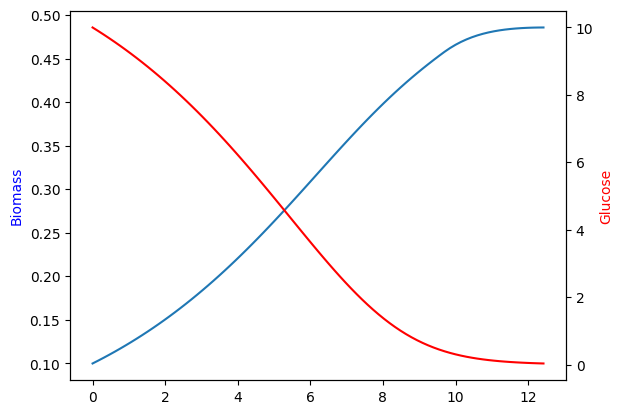

In [ ]:
ax = plt.subplot(111)
ax.plot(sol.t, sol.y.T[:, 0])
ax2 = plt.twinx(ax)
ax2.plot(sol.t, sol.y.T[:, 1], color='r')

ax.set_ylabel('Biomass', color='b')
ax2.set_ylabel('Glucose', color='r')

## DFBA with out model and progesterone production

In [ ]:
from cobra.io import read_sbml_model

In [1]:
model = read_sbml_model('../../models/iMM904_progesterone_fixed.xml')

#fba_model.add_boundary(fba_model.metabolites.get_by_id('progesterone_e'), type='exchange')
model.add_boundary(model.metabolites.get_by_id('progesterone_c'), type='demand')

model.objective = model.reactions.R02216
model.optimize().objective_value

NameError: name 'read_sbml_model' is not defined

In [29]:
def add_dynamic_bounds(model, y):
    """Use external concentrations to bound the uptake flux of glucose."""
    biomass, glucose = y  # expand the boundary species
    glucose_max_import = -10 * glucose / (5 + glucose)
    model.reactions.EX_glc__D_e.lower_bound = glucose_max_import

def dynamic_system(t, y):
    """Calculate the time derivative of external species."""

    biomass, glucose = y  # expand the boundary species

    # Calculate the specific exchanges fluxes at the given external concentrations.
    with model:
        add_dynamic_bounds(model, y)
        
        cobra.util.add_lp_feasibility(model)
        feasibility = cobra.util.fix_objective_as_constraint(model)
        lex_constraints = cobra.util.add_lexicographic_constraints(
            model, ['BIOMASSE', 'EX_glc__D_e', 'progesterone_c'], ['max','max','max'])

    # Since the calculated fluxes are specific rates, we multiply them by the
    # biomass concentration to get the bulk exchange rates.
    fluxes = lex_constraints.values
    fluxes *= biomass

    # This implementation is **not** efficient, so I display the current
    # simulation time using a progress bar.
    if dynamic_system.pbar is not None:
        dynamic_system.pbar.update(1)
        dynamic_system.pbar.set_description('t = {:.3f}'.format(t))

    return fluxes

dynamic_system.pbar = None

def infeasible_event(t, y):
    """
    Determine solution feasibility.

    Avoiding infeasible solutions is handled by solve_ivp's built-in event detection.
    This function re-solves the LP to determine whether or not the solution is feasible
    (and if not, how far it is from feasibility). When the sign of this function changes
    from -epsilon to positive, we know the solution is no longer feasible.

    """

    with model:

        add_dynamic_bounds(model, y)

        cobra.util.add_lp_feasibility(model)
        feasibility = cobra.util.fix_objective_as_constraint(model)

    return feasibility - infeasible_event.epsilon

infeasible_event.epsilon = 1E-6
infeasible_event.direction = 1
infeasible_event.terminal = True

In [33]:
ts = np.linspace(0, 15, 100)  # Desired integration resolution and interval
y0 = [0.1, 10]

with tqdm() as pbar:
    dynamic_system.pbar = pbar

    sol = solve_ivp(
        fun=dynamic_system,
        events=[infeasible_event],
        t_span=(ts.min(), ts.max()),
        y0=y0,
        t_eval=ts,
        rtol=1e-6,
        atol=1e-8,
        method='BDF'
    )

t = 14.322: : 348it [23:04,  3.98s/it]


In [34]:
sol

  message: 'A termination event occurred.'
     nfev: 335
     njev: 4
      nlu: 25
      sol: None
   status: 1
  success: True
        t: array([ 0.        ,  0.15151515,  0.3030303 ,  0.45454545,  0.60606061,
        0.75757576,  0.90909091,  1.06060606,  1.21212121,  1.36363636,
        1.51515152,  1.66666667,  1.81818182,  1.96969697,  2.12121212,
        2.27272727,  2.42424242,  2.57575758,  2.72727273,  2.87878788,
        3.03030303,  3.18181818,  3.33333333,  3.48484848,  3.63636364,
        3.78787879,  3.93939394,  4.09090909,  4.24242424,  4.39393939,
        4.54545455,  4.6969697 ,  4.84848485,  5.        ,  5.15151515,
        5.3030303 ,  5.45454545,  5.60606061,  5.75757576,  5.90909091,
        6.06060606,  6.21212121,  6.36363636,  6.51515152,  6.66666667,
        6.81818182,  6.96969697,  7.12121212,  7.27272727,  7.42424242,
        7.57575758,  7.72727273,  7.87878788,  8.03030303,  8.18181818,
        8.33333333,  8.48484848,  8.63636364,  8.78787879,  8.93939

Text(0, 0.5, 'Glucose')

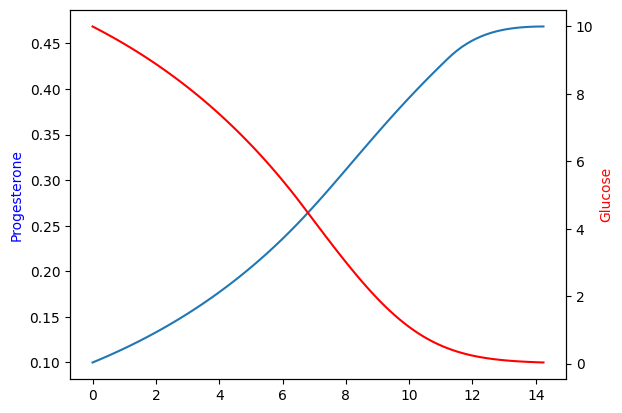

In [36]:
ax = plt.subplot(111)
ax.plot(sol.t, sol.y.T[:, 0])
ax2 = plt.twinx(ax)
ax2.plot(sol.t, sol.y.T[:, 1], color='r')

ax.set_ylabel('Progesterone', color='b')
ax2.set_ylabel('Glucose', color='r')

model.metabolites.progesterone_c